In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import os
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_recall_curve,
    average_precision_score, roc_curve, auc, f1_score, precision_score, recall_score
)
import seaborn as sns
import pickle

# Raport z budowy modeli

## Selekcja atrybutów
Aby wybrać atrybuty wykorzystywane do modelowania przeanalizowano wagi modelu regresji logicznej dla ustandaryzowanych danych.

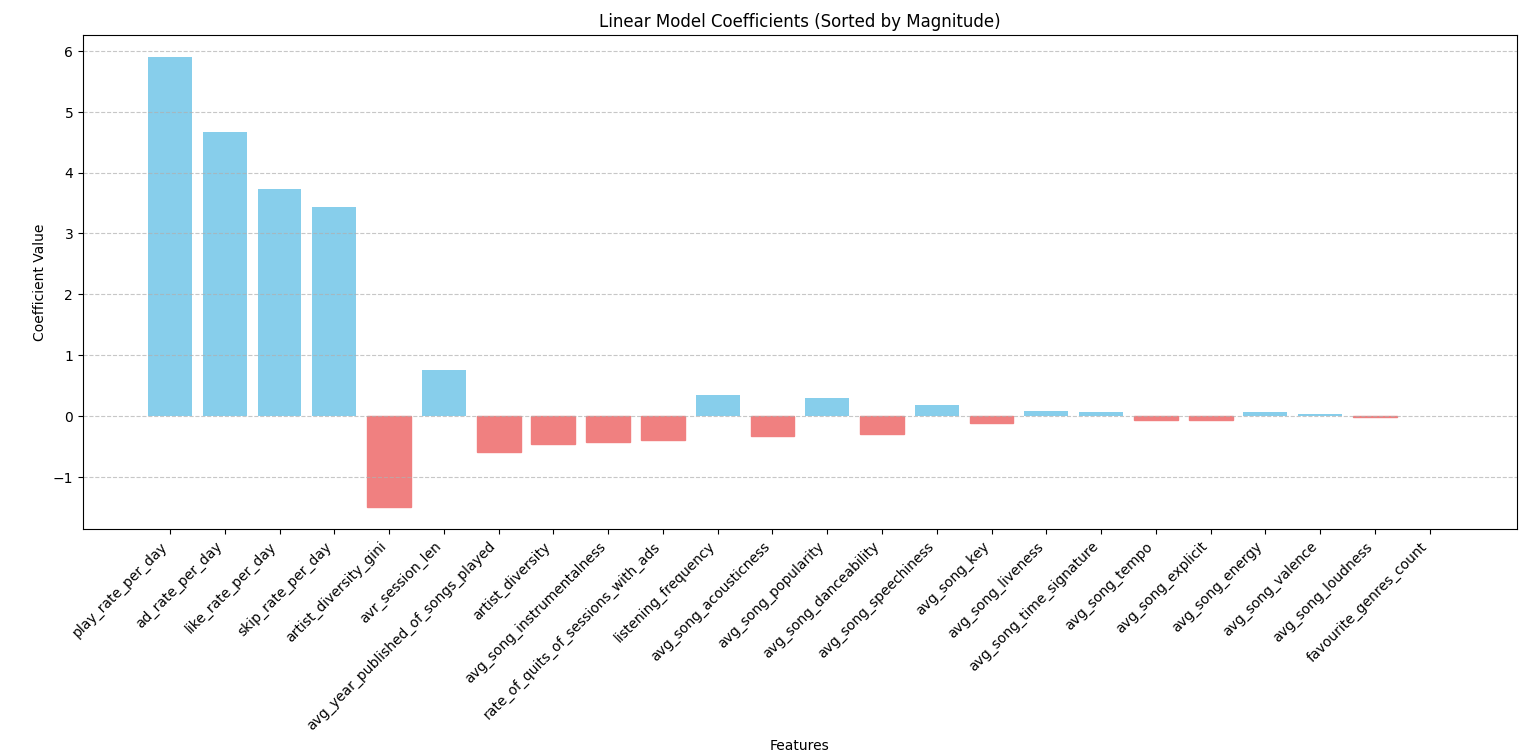

Jak widać na powyższym wykresie, najbardziej znaczące są atrybuty odnoszące się do zachowań użytkowanika na platformie. Najmniej istotne są parametry mówiące o typie muzyki słuchanej przez użytkownika. Po przeanalizowaniu wag modelu wybrano 6 najbardziej istotnych atrybutów do wykorzystania w dalszym modelowaniu. Dzięki zmniejszeniu ilości używanych atrybutów łatwiejsze będzie utrzymanie modelu a także korzystanie z niego.

### Analiza jakości modelu po selekcji atrybutów
Do analizy jakości modelu po selekcji atrybutów wykorzystano wszystkie dane ponieważ wyniki te nie są wykorzystywane w procesie strojenia modeli, lecz służą jedynie do pokazania, że modele mają podobną jakość pomimo zmniejszenia ilości atrybutów.

In [7]:

X_processed_full = pd.read_csv('data/processed_X.csv')
X_all_attributes_full = pd.read_csv('data/all_attributes_X.csv')
Y_full = pd.read_csv('data/processed_Y.csv')

train_ratio = 0.8  # 80% for training and 20% for validation
full_data_ratio = 1
indices = np.arange(int(full_data_ratio*len(Y_full)))
NUMBER_OF_SAMPLES = 1000
all_atributes_score = []
selected_attributes_score = []
for i in tqdm(range(NUMBER_OF_SAMPLES)):
    np.random.seed(i) #@V2 - dodanie ziarna generatora aby można było powtórzyć eksperyment
    np.random.shuffle(indices)

    train_size = int(len(indices) * train_ratio)
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    Xp_train = X_processed_full.iloc[train_indices]
    Xall_train = X_all_attributes_full.iloc[train_indices]
    Y_train = Y_full.iloc[train_indices]

    Xp_val = X_processed_full.iloc[val_indices]
    Xall_val = X_all_attributes_full.iloc[val_indices]
    Y_val = Y_full.iloc[val_indices]
    Y_train = Y_train.to_numpy().ravel()
    Y_val = Y_val.to_numpy().ravel()


    scaler = StandardScaler()
    Xp_train_scaled = scaler.fit_transform(Xp_train)
    Xp_val_scaled = scaler.transform(Xp_val)


    scaler = StandardScaler()

    Xall_train_scaled = scaler.fit_transform(Xall_train)
    Xall_val_scaled = scaler.transform(Xall_val)

    model = LogisticRegression()
    model.fit(Xp_train_scaled, Y_train)
    selected_attributes_score.append(accuracy_score(Y_val, model.predict(Xp_val_scaled)))
    model = LogisticRegression()
    model.fit(Xall_train_scaled, Y_train)
    all_atributes_score.append(accuracy_score(Y_val, model.predict(Xall_val_scaled)))
print(f"Selected Attributes: Mean Model accuracy {np.mean(selected_attributes_score)}, Variance {np.var(selected_attributes_score)}")
print(f"All Attributes: Mean Model accuracy {np.mean(all_atributes_score)}, Variance {np.var(all_atributes_score)}")

100%|██████████| 1000/1000 [00:23<00:00, 42.66it/s]

Selected Attributes: Mean Model accuracy 0.8060433333333333, Variance 0.00019370034444444442
All Attributes: Mean Model accuracy 0.8057133333333334, Variance 0.0001937300444444444


### Wnioski
Jak widać po selekcji atrybutów model osiąga podobną jakość co przy wszystkich atrybutach a dodatkowo łatwiej jest go utrzymać w produkcji. Dodatkowo warto zauważyć, że wariancja dokładności modeli nie zmienia się znacząco w zależności od ilości atrybutów. Oznacza to, że dodatkowe atrybuty nie zmniejszają "stabilności" modelu. 

## Dobór hiperparametrów modelu zaawansowanego

In [8]:
def load_data(base_path='data/'):
    X_train = pd.read_csv(f'{base_path}X_train.csv')
    X_val = pd.read_csv(f'{base_path}X_val.csv')
    X_test = pd.read_csv(f'{base_path}X_test.csv')
    Y_test = pd.read_csv(f'{base_path}Y_test.csv')
    Y_train = pd.read_csv(f'{base_path}Y_train.csv')
    Y_val = pd.read_csv(f'{base_path}Y_val.csv')
    return X_train, X_val,X_test, Y_train, Y_val,Y_test
X_train, X_val,_, Y_train, Y_val, _ = load_data()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [9]:
n_estimators_range = [*range(10,500,20)]
number_to_sample = 10
criterions = ["gini", "entropy", "log_loss"]
results = {}
for criterion in criterions:
    print(f"Processing '{criterion}'")
    train_scores = []
    val_scores = []
    for n_estimators in tqdm(n_estimators_range):
        train_score = []
        val_score = []
        for i in range(number_to_sample):
            rf_model = RandomForestClassifier(criterion=criterion,n_estimators=n_estimators, random_state=i+30)
            rf_model.fit(X_train_scaled, Y_train.values.ravel())

            train_pred = rf_model.predict(X_train_scaled)
            val_pred = rf_model.predict(X_val_scaled)
            train_score.append(accuracy_score(Y_train, train_pred))
            val_score.append(accuracy_score(Y_val, val_pred))

        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))
    results[criterion] = {"training_accuracy":train_scores, "validation_accuracy":val_scores}


Processing 'gini'


 92%|█████████▏| 23/25 [05:09<00:26, 13.46s/it]


KeyboardInterrupt: 

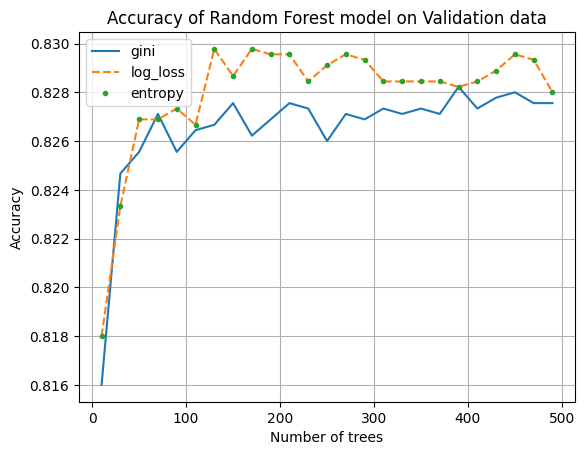

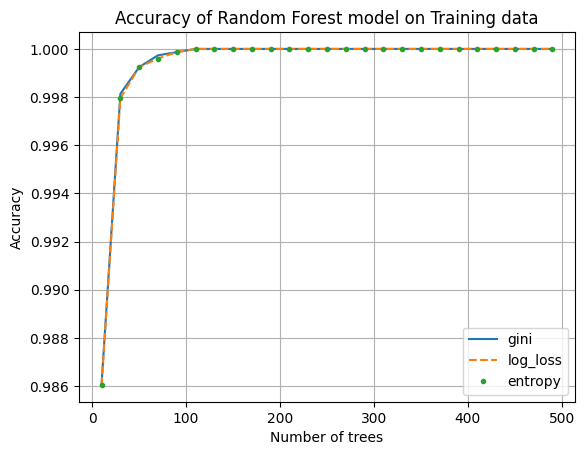

In [ ]:
plt.clf()
plt.plot(n_estimators_range, results["gini"]["validation_accuracy"], label="gini")
plt.plot(n_estimators_range, results["log_loss"]["validation_accuracy"],"--", label="log_loss")
plt.plot(n_estimators_range, results["entropy"]["validation_accuracy"],".", label="entropy")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Number of trees")
plt.title("Accuracy of Random Forest model on Validation data")
plt.grid()
plt.show()

plt.clf()
plt.plot(n_estimators_range, results["gini"]["training_accuracy"], label="gini")
plt.plot(n_estimators_range, results["log_loss"]["training_accuracy"],"--", label="log_loss")
plt.plot(n_estimators_range, results["entropy"]["training_accuracy"],".", label="entropy")

plt.legend()
plt.ylabel('Accuracy')
plt.xlabel("Number of trees")
plt.title("Accuracy of Random Forest model on Training data")
plt.grid()
plt.show()
# print(results)

Jak widać dokładność modelu zmienia się nieznacznie w zależności od ilości drzew w modelu. Kryteria podziału także nie mają dużego wpływu na zachowanie modelu. Ciekawe jest to że pomimo zwiększania ilości drzew błąd na danych treningowych nie maleje tylko jest stały.

Na podstawie powyższysch wyników wybrano kryterium "entropy" oraz 100 drzew ponieważ większa ilość drzew nie zmienia znacząco jakości modelu.

## Porównanie wytrenowanych modeli
Modele zostały porównane na danych testowych, które nie były wykorzystywane w procesie uczenia modeli i dobierania ich hiperparametrów.

*Załadowanie modeli i zdefiniowanie funkcji do ich porównania*

In [ ]:
BASE_MODEL_PATH = 'data/models/logistic_regression.pkl'
ADVANCED_MODEL_PATH = 'data/models/random_forest.pkl'
SCALER_PATH = 'data/models/data_scaler.pkl'
from helper_functions_for_raport import *
try:
    with open(SCALER_PATH,'rb') as f:
        scaler = pickle.load(f)
    with open(BASE_MODEL_PATH, 'rb') as f:
        base_model = pickle.load(f)
    with open(ADVANCED_MODEL_PATH, 'rb') as f:
        advanced_model = pickle.load(f)
except FileNotFoundError as e:
    raise RuntimeError("Nie udało się załadować modeli. Sprawdź pliki .pkl.")



_, _,X_test, _, _,Y_test = load_data()
Y_pred_base, Y_prob_base = get_model_responses(scaler,base_model,X_test)
Y_pred_adv, Y_prob_adv = get_model_responses(scaler,advanced_model,X_test)

### Analiza wskaźników jakości
W zadaniu klasyfikacji użytkowników premium pod dostosowywanie rekomendacji preferowane będą nadmiernie pozytywne predykcje - nie chciane są przypadki gdzie użytkownik ma predyspozycje do zakupu konta premium a model tego nie przewidzi.

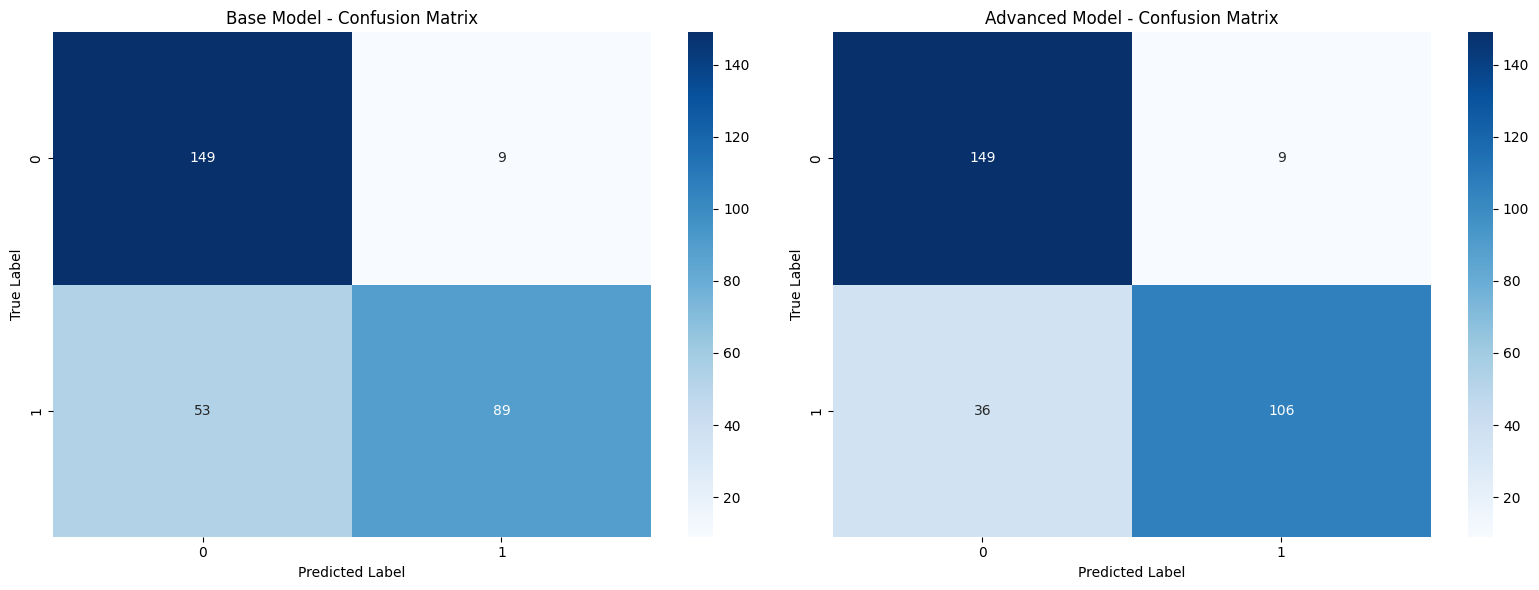

In [ ]:
plot_model_confusion_matrices(Y_test,Y_pred_base,Y_test,Y_pred_adv,"Base Model","Advanced Model")

Jak widać na macierzach pomyłek, główną różnicą w zachowaniu modeli jest to, że w zaawansowanym modelu rzadziej występują fałszywie pozytywne przypadki, czyli te, w których model niepoprawnie przewiduje, że użytkownik nie ma konta premium.

Modele częściej popełniają błąd zakładając brak konta premium niż jego posiadanie w przypadku gdy go nie ma. Przyczyną jest prawdopodobnie przewaga użytkowników bez konta premium w danych treningowych.

In [ ]:
metrics_base = calculate_model_metrics(Y_test,Y_pred_base)
metrics_adv = calculate_model_metrics(Y_test,Y_pred_adv)
print_comparison_table(metrics_base,metrics_adv,"Base Model","Advanced Model")

Metric    |Base Model |Advanced Model 
accuracy  |   0.793   |   0.850 
precision |   0.908   |   0.922 
recall    |   0.627   |   0.746 
TNR       |   0.943   |   0.943 
f1        |   0.742   |   0.825 


Opis wskaźników:
- **Accuracy (dokładność)** - Procent poprawnie zaklasyfikowanych klas
- **Precision (precyzja)** - *(tp / (tp + fp))* - Jak często predykcje pozytywne są trafne
- **Recall/True positive rate (odzysk)** - *(tp / (tp + fn))*  - skuteczność z jaką model wykrywa przypadki pozytywne
- **True Negative Rate** - *(tn / (fn + tn))* - skuteczność z jaką model wykrywa przypadki negatywne
- **F1-score** - średnia harmoniczna precyzji i odzysku

W powyższej tabeli widać, że model zaawansowany cechuje się większą dokładnością. Spowodowane to jest lepszą identyfikacją klas pozytywnych, co widać poprzez zwiększenie precyzji modelu oraz odzysku. TNR jest takie same w obydwu modelach co widać na macierzach pomyłek - jakość klasyfikacji braku kont premium jest taka sama w obu modelach. Poprawa w precyzji i odzysku odzwierciedlona jest w F1-score ponieważ jest to średnia harmoniczna obu wskaźników.

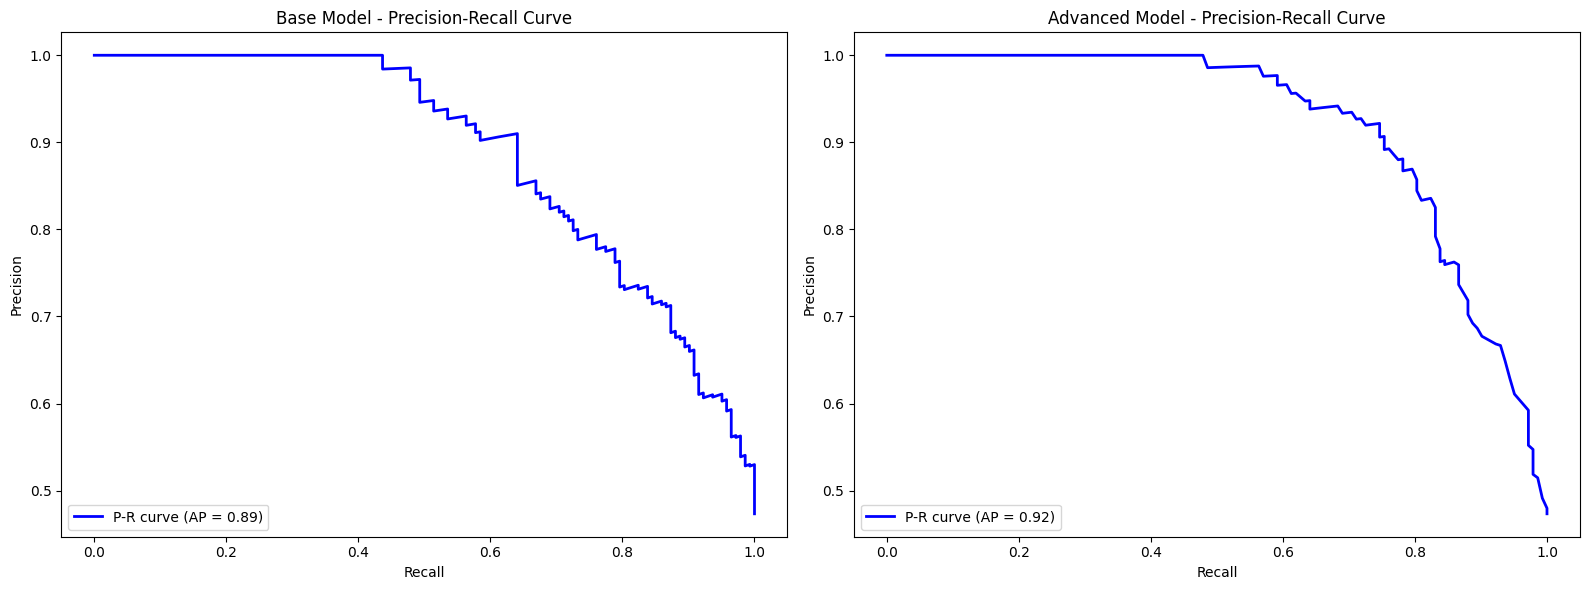

In [ ]:
_ = plot_model_pr_curves(Y_test,Y_prob_base,Y_test,Y_prob_adv,"Base Model","Advanced Model")

W przypadku klasyfikacji użytkowników premium chcemy zmaksymalizować odzysk, aby nie przeoczyć użytkowników z odpowiednimi predyspozycjami do zakupu. Jednocześnie należy zachować precyzję, która informuje o tym, jak często predykcje pozytywne są trafne. Na powyższych wykresach widać, że model zaawansowany utrzymuje wysoką precyzję nawet przy wysokim odzysku na poziomie 80%. W przypadku gdy po analizie działania tych modeli potrzebny byłby bardziej optymistyczny model, można zastosować model zaawansowany, modyfikując jego punkt pracy tak, aby wciąż osiągać precyzję rzędu 90%, jednocześnie uzyskując lepszy odzysk.

### Obserwacje i wnioski
Oba modele efektywnie klasyfikują użytkowników premium, przy czym model zaawansowany wykazuje się lepszymi metrykami jakości klasyfikacji. 

W przyszłych pracach dobrze będzie przeanalizować i zoptymalizować punkty pracy modeli tak, aby lepiej spełniały wymagania biznesowe. Dodatkowo w kolejnych projektach planowane jest zastosowanie słabszego modelu bazowego, co usprawni proces porównawczy.

# Analiza pod względem wymagań (@v2)

## Spełnienie kryteriów analitycznych
- Model podstawowy osiągnął dokładność 79%, a zaawansowany 85%, znacząco przekraczając zakładany próg 60%
- Wszystkie pozostałe wskaźniki wykazały większą skuteczność modelu zaawansowanego zgodnie z założeniami.
- Test A/B wykazał, że model zaawansowany jest bardziej dokłądny niż model bazowy 

## Spełnienie kryteriów biznesowych
- Po analizie A/B można też stwierdzić że rozwiązanie może spełnić wymagania biznesowe klienta lecz wymaga to dodatkowej weryfikacji po wdrożeniu.